# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></div><div class="lev2 toc-item"><a href="#Parse-input" data-toc-modified-id="Parse-input-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Parse input</a></div><div class="lev1 toc-item"><a href="#Overview-visualization" data-toc-modified-id="Overview-visualization-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Overview visualization</a></div><div class="lev1 toc-item"><a href="#Differential-expression" data-toc-modified-id="Differential-expression-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Differential expression</a></div><div class="lev2 toc-item"><a href="#Without-batch-correction" data-toc-modified-id="Without-batch-correction-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Without batch correction</a></div><div class="lev2 toc-item"><a href="#With-batch-correction" data-toc-modified-id="With-batch-correction-32"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>With batch correction</a></div><div class="lev1 toc-item"><a href="#Run-ComBat-to-adjust" data-toc-modified-id="Run-ComBat-to-adjust-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Run ComBat to adjust</a></div><div class="lev2 toc-item"><a href="#ComBat-modelling-condition" data-toc-modified-id="ComBat-modelling-condition-41"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>ComBat modelling condition</a></div><div class="lev3 toc-item"><a href="#Statistics" data-toc-modified-id="Statistics-411"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Statistics</a></div><div class="lev2 toc-item"><a href="#ComBat-not-modelling-biological-factor" data-toc-modified-id="ComBat-not-modelling-biological-factor-42"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>ComBat not modelling biological factor</a></div><div class="lev3 toc-item"><a href="#Statistics" data-toc-modified-id="Statistics-421"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>Statistics</a></div><div class="lev1 toc-item"><a href="#Estimate-surrogate-variation" data-toc-modified-id="Estimate-surrogate-variation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Estimate surrogate variation</a></div><div class="lev1 toc-item"><a href="#Summarize-significance" data-toc-modified-id="Summarize-significance-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Summarize significance</a></div>

# Setup

In [48]:
run <- "example_data"
expression_fp <- paste0(run, "/full_quant.tsv")
design_fp <- paste0(run, "/design.tsv")

In [49]:
library(ggplot2)
library(ggfortify)
library(ggdendro)
library(limma)
library(gridExtra)
library(sva)

source("util_scripts/proteomics_multivariate_vis.R")
source("util_scripts/visualization_utils.R")
source("util_scripts/proteomics_stats.R")

In [50]:
plot_pca <- function(data_m, design_m, pc1, pc2, color_factor, colors, custom_names, legend=T, title_app="", cont_scale=F) {
    
    if (!cont_scale) {
        getPalette <- colorRampPalette(RColorBrewer::brewer.pal(9, "Set1"))        
    }
    title <- paste0("PCA, PC", pc1, " vs PC", pc2, " ", title_app)
    plt <- make_expression_pca(data_m, design_m, color_factor=color_factor, title=title, 
                               pca_axis1=pc1, pca_axis2=pc2, show_labels=T,
                               only_text=T, color_text=T, custom_names=custom_names)
    if (!cont_scale) {
        plt <- plt + scale_color_manual(values=getPalette(colors))        
    }
    
    if (!legend) {
        plt <- plt + theme(legend.position="none")
    }
    
    plt
}

## Parse input

In [51]:
design_df <- read.csv(design_fp, sep="\t")
design_df$sample <- design_df$name
design_df$batch <- as.factor(design_df$batch)
print(design_df)

   name biorepgroup techrepgroup condition batch sample
1    a1           1            1         a     1     a1
2    a2           2            1         a     1     a2
3    a3           3            1         a     1     a3
4    a4           4            1         a     2     a4
5    a5           5            1         a     2     a5
6    a6           6            1         a     2     a6
7    b1           1            1         b     1     b1
8    b2           2            1         b     1     b2
9    b3           3            1         b     1     b3
10   b4           4            1         b     2     b4
11   b5           5            1         b     2     b5
12   b6           6            1         b     2     b6


In [52]:
raw_data_df <- read.csv(expression_fp, sep="\t")
head(raw_data_df)
raw_data_df$peptide <- as.character(raw_data_df$peptide)
raw_data_df$protein <- as.character(raw_data_df$protein)
data_df <- log2(raw_data_df[, as.character(design_df$name)])
head(data_df)

peptide,protein,a1,a2,a3,a4,a5,a6,b1,b2,b3,b4,b5,b6
CLK,sp|P37127|AEGA_ECOLI,27859100,47199200,48350400,87030800,64006700,66078900,36854100,21648000,29196300,72337000,73013000,74365200
FCR,sp|P0A7T7|RS18_ECOLI,140711604,102465796,120203200,175086700,200098700,179798000,119185600,210603108,166641100,135449704,169127700,168260400
LCR,sp|Q9JMR4|YUBK_ECOLI,49510300,59627600,34226700,61134400,79216496,65654900,41219500,50987400,55255100,80637000,77535504,96989904
FCQR,sp|P39357|YJHF_ECOLI,144461200,112001696,140922100,206195008,225476008,166140600,235997400,85933000,89382100,226930208,133279800,205833292
FLFK,sp|P34094|PHYB_SOLTU,99838500,109387700,138451200,202539600,163332600,157562700,227359600,250199192,231104092,408702200,366921216,383277616
FYLS,sp|A5A617|YDGU_ECOLI,81157104,71129400,51876400,109368000,99474200,98939400,92791800,95682704,88006096,213711,272874,290985


a1,a2,a3,a4,a5,a6,b1,b2,b3,b4,b5,b6
24.73165,25.49226,25.52702,26.37502,25.93172,25.97769,25.13532,24.36773,24.79928,26.10823,26.12165,26.14812
27.06817,26.61057,26.84090,27.38349,27.57614,27.42180,26.82863,27.64995,27.31217,27.01318,27.33354,27.32612
25.56123,25.82948,25.02862,25.86548,26.23930,25.96840,25.29682,25.60364,25.71960,26.26494,26.20835,26.53133
27.10611,26.73895,27.07032,27.61943,27.74840,27.30783,27.81420,26.35671,26.41348,27.75767,26.98988,27.61690
26.57309,26.70488,27.04480,27.59363,27.28324,27.23135,27.76040,27.89850,27.78397,28.60647,28.45090,28.51381
26.27421,26.08394,25.62858,26.70462,26.56782,26.56004,26.46749,26.51175,26.39110,17.70530,18.05788,18.15059


In [53]:
parse_annot <- function(annot_string) {
    
    fields <- unlist(strsplit(as.character(annot_string), "/"))
    annot <- sapply(fields, function(field) { unlist(strsplit(field, "_"))[[2]] })
    
    if (annot == "SOLTU") {
        TRUE
    }
    else if (annot == "ECOLI") {
        FALSE
    }
    else {
        stop(paste0("Unknown annotation: ", annot))
    }
}

In [54]:
spike_col <- sapply(as.character(raw_data_df[, "protein"]), parse_annot)
head(spike_col)


sp|P37127|AEGA_ECOLI sp|P0A7T7|RS18_ECOLI sp|Q9JMR4|YUBK_ECOLI 
               FALSE                FALSE                FALSE 
sp|P39357|YJHF_ECOLI sp|P34094|PHYB_SOLTU sp|A5A617|YDGU_ECOLI 
               FALSE                 TRUE                FALSE

# Overview visualization

Clustering of unadjusted based on main principal components. Conditions are distinguished 'a' and 'b', while batches are distinguished by color. 

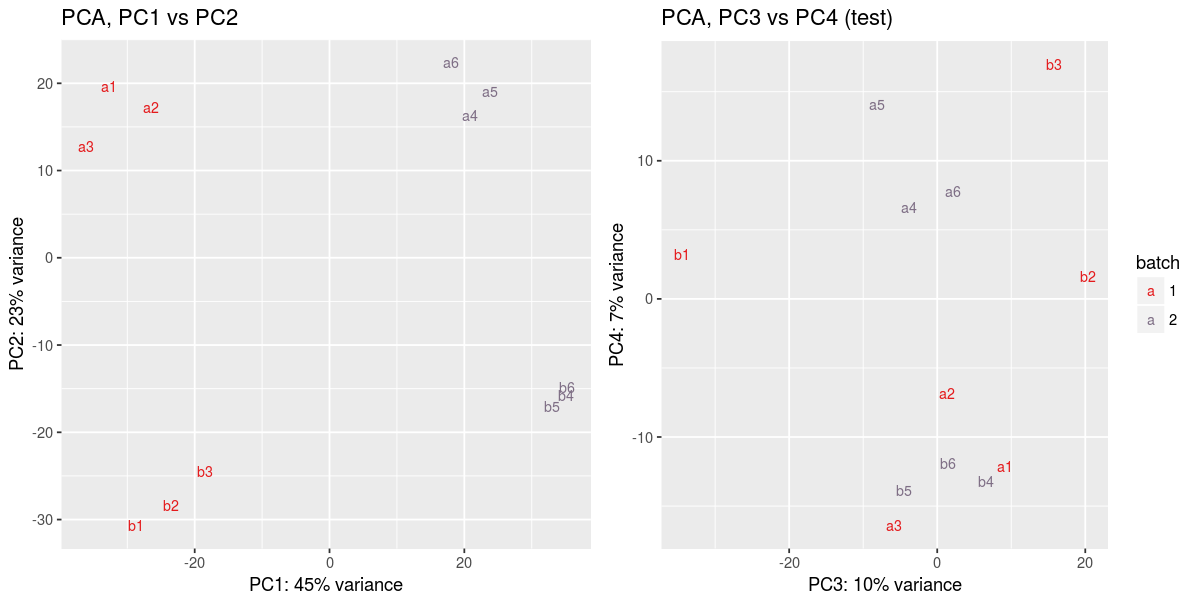

In [46]:
p1_1 <- plot_pca(data_df, design_df, 1, 2, "batch", colors=4, custom_names=design_df$name, legend=F)
p1_2 <- plot_pca(data_df, design_df, 3, 4, "batch", colors=4, custom_names=design_df$name, legend=T, title_app="(test)")
options(repr.plot.width=10, repr.plot.height=5)
multiplot(p1_1, p1_2, cols=2)


# Differential expression

Differential expression is performed by applying an ANOVA comparing the samples from condition 'a' and condition 'b'. This is performed both without and with compensation for the batch factor.

In [47]:
sig_vectors <- list()
q_vectors <- list()

In [55]:
calculate_anova <- function(row, cond, batch=NULL) {
    
    if (!is.null(batch)) {
        anova_df <- data.frame(cbind(Intensity=unlist(row), Cond=cond, Batch=batch))        
        av <- aov(Intensity~Cond+Batch, anova_df)        
    }
    else {
        anova_df <- data.frame(cbind(Intensity=unlist(row), Cond=cond))
        av <- aov(Intensity~Cond, anova_df)                
    }
    
    av_summary <- summary(av)
    p_val <- av_summary[[1]]["Cond", "Pr(>F)"]
    p_val
}

In [56]:
get_truth_vector <- function(measured_pos_vect, actually_pos_vect) {
    
    truth_vector <- c()
    
    for (i in 1:length(measured_pos_vect)) {
        
        measured_pos <- measured_pos_vect[i]
        actually_pos <- actually_pos_vect[i]
        
        if (measured_pos && actually_pos) {
            outcome <- "TP"
        }
        else if (!measured_pos && !actually_pos) {
            outcome <- "TN"
        }
        else if (measured_pos && !actually_pos) {
            outcome <- "FP"
        }
        else if (!measured_pos && actually_pos) {
            outcome <- "FN"
        }
        else {
            stop(paste("Unknown state, measured_pos:", measured_pos, 
                       ", actually_pos:", actually_pos))
        }
        
        truth_vector <- c(truth_vector, outcome)
    }
    
    truth_vector
}

print_truth_summary <- function(truth_vector) {
    
    truth_table <- table(truth_vector)
    print(truth_table)
    
    FN <- truth_table["FN"]
    FP <- truth_table["FP"]
    TN <- truth_table["TN"]
    TP <- truth_table["TP"]
    
    specificity <- TN / (TN + FP)
    precision <- TP / (TP + FP)
    recall <- TP / (TP + FN)
    fscore <- 2 * (precision * recall) / (precision + recall)
    
    print(paste("Precision:", round(precision, 3)))
    print(paste("Specificity:", round(specificity, 3)))
    print(paste("Recall:", round(recall, 3)))
    print(paste("F-score:", round(fscore, 3)))
}

## Without batch correction

Investigating differential expression on data without any batch-effect compensation.

In [13]:
print("Without batch correction")

p_vals <- unlist(apply(data_df, 1, calculate_anova, cond=design_df$condition))
q_vals <- as.numeric(p.adjust(p_vals, method="BH"))
sig_indices <- which(q_vals < 0.1)

print(paste("P-vals below 0.1:", length(p_vals[which(p_vals < 0.1)])))
print(paste("Spike-in count:", length(spike_col[spike_col])))
print(paste("Passing FDR threshold:", length(q_vals[which(q_vals < 0.1)])))

truth_vector <- get_truth_vector(q_vals < 0.1, spike_col)
print_truth_summary(truth_vector)

sig_vectors[["default"]] <- truth_vector
q_vectors[["default"]] <- q_vals

[1] "Without batch correction"
[1] "P-vals below 0.1: 691"
[1] "Spike-in count: 424"
[1] "Passing FDR threshold: 505"
truth_vector
  FN   FP   TN   TP 
  76  157 1364  348 
[1] "Precision: 0.689"
[1] "Specificity: 0.897"
[1] "Recall: 0.821"
[1] "F-score: 0.749"


## With batch correction

Investigating differential expression on data while including the batch effect as a factor used for the ANOVA model.

In [14]:
print("With batch correction")

p_vals <- unlist(apply(data_df, 1, calculate_anova, cond=design_df$condition, batch=design_df$batch))
q_vals <- as.numeric(p.adjust(p_vals, method="BH"))
sig_indices <- which(q_vals < 0.1)

print(paste("P-vals below 0.1:", length(p_vals[which(p_vals < 0.1)])))
print(paste("Spike-in count:", length(spike_col[spike_col])))
print(paste("Passing FDR threshold:", length(q_vals[which(q_vals < 0.1)])))

truth_vector <- get_truth_vector(q_vals < 0.1, spike_col)
print_truth_summary(truth_vector)
sig_vectors[["batch_corr"]] <- truth_vector
q_vectors[["batch_corr"]] <- q_vals

[1] "With batch correction"
[1] "P-vals below 0.1: 931"
[1] "Spike-in count: 424"
[1] "Passing FDR threshold: 754"
truth_vector
  FN   FP   TN   TP 
  45  375 1146  379 
[1] "Precision: 0.503"
[1] "Specificity: 0.753"
[1] "Recall: 0.894"
[1] "F-score: 0.643"


# Run ComBat to adjust

ComBat is an algorithm attempting to identify and remove batch effects from expression data. It produces a new dataset which then in turn is used for differential expression between the conditions.

## ComBat modelling condition

Here, the condition is included in the ComBat modelling.

In [57]:
modcombat <- model.matrix(~1+condition, data=design_df)
modcombat

,(Intercept),conditionb
1,1,0
2,1,0
3,1,0
4,1,0
5,1,0
6,1,0
7,1,1
8,1,1
9,1,1
10,1,1


Found 2 batches
Adjusting for 1 covariate(s) or covariate level(s)
Standardizing Data across genes
Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data


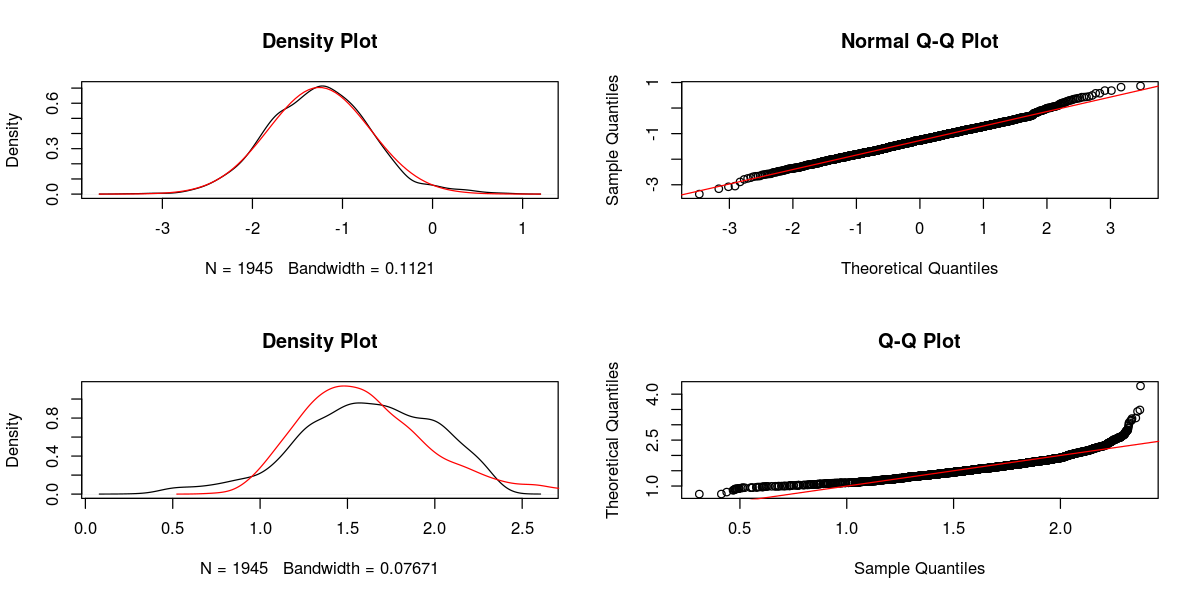

In [21]:
combat_data_df <- ComBat(dat=data_df, batch=design_df$batch, mod=modcombat, par.prior=TRUE, prior.plots=TRUE)

In [22]:
head(combat_data_df)

a1,a2,a3,a4,a5,a6,b1,b2,b3,b4,b5,b6
25.29990,25.89727,25.92457,25.91697,25.37234,25.42881,25.56847,24.96562,25.30455,25.64082,25.65731,25.68983
27.26883,26.90736,27.08931,27.19215,27.41855,27.23717,27.09931,27.74809,27.48127,26.74052,27.11701,27.10830
25.84725,26.05939,25.42607,25.50047,25.95178,25.62473,25.67764,25.92027,26.01197,25.94362,25.87531,26.26524
27.44510,27.15594,27.41692,27.27336,27.43068,26.89326,27.98002,26.83217,26.87688,27.46552,26.52895,27.29380
26.88014,26.98467,27.25429,27.33587,26.99732,26.94073,28.04881,28.15835,28.06750,28.34106,28.17137,28.24000
26.49451,26.34706,25.99420,26.91221,26.78047,26.77298,25.72382,25.75812,25.66463,18.09454,18.43407,18.52335


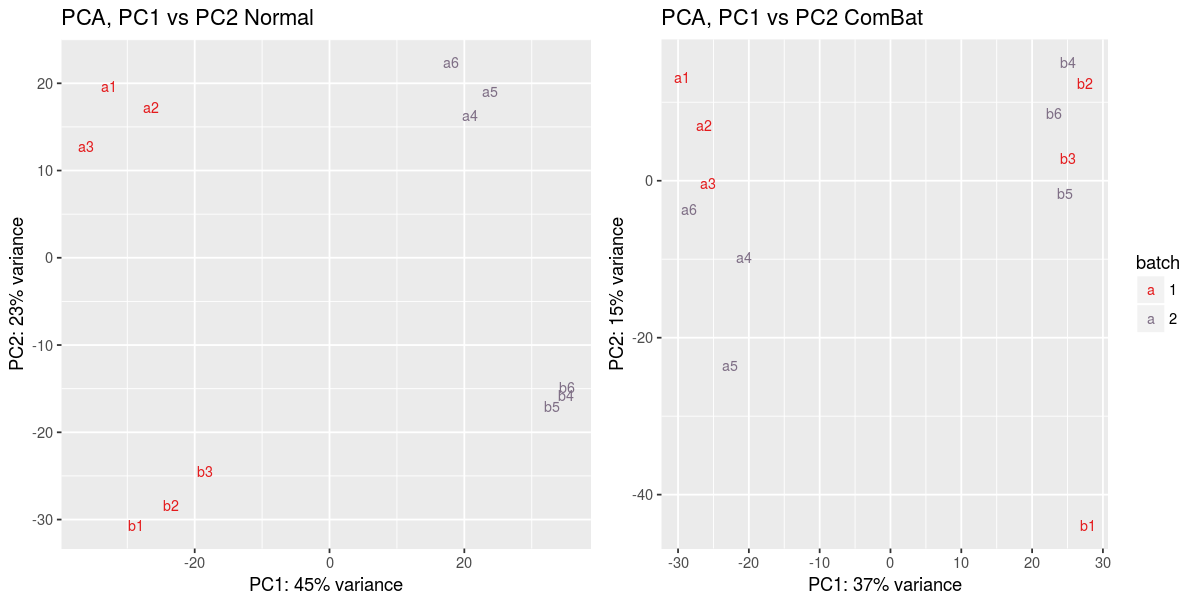

In [23]:
p1_1 <- plot_pca(data_df, design_df, 1, 2, "batch", colors=4, custom_names=design_df$name, legend=F, title_app="Normal")
p1_2 <- plot_pca(combat_data_df, design_df, 1, 2, "batch", colors=4, custom_names=design_df$name, legend=T, title_app="ComBat")
options(repr.plot.width=10, repr.plot.height=5)
multiplot(p1_1, p1_2, cols=2)


### Statistics

In [24]:
print("ComBat statistics")

p_vals <- unlist(apply(combat_data_df, 1, calculate_anova, cond=design_df$condition))
q_vals <- as.numeric(p.adjust(p_vals, method="BH"))
sig_indices <- which(q_vals < 0.1)

print(paste("P-vals below 0.1:", length(p_vals[which(p_vals < 0.1)])))
print(paste("Spike-in count:", length(spike_col[spike_col])))
print(paste("Passing FDR threshold:", length(q_vals[which(q_vals < 0.1)])))

truth_vector <- get_truth_vector(q_vals < 0.1, spike_col)
print_truth_summary(truth_vector)
sig_vectors[["combat"]] <- truth_vector
q_vectors[["combat"]] <- q_vals

[1] "ComBat statistics"
[1] "P-vals below 0.1: 1022"
[1] "Spike-in count: 424"
[1] "Passing FDR threshold: 867"
truth_vector
  FN   FP   TN   TP 
  39  482 1039  385 
[1] "Precision: 0.444"
[1] "Specificity: 0.683"
[1] "Recall: 0.908"
[1] "F-score: 0.596"


## ComBat not modelling biological factor

In [25]:
modcombat <- model.matrix(~1, data=design_df)
head(modcombat)

,(Intercept)
1,1
2,1
3,1
4,1
5,1
6,1


Found 2 batches
Adjusting for 0 covariate(s) or covariate level(s)
Standardizing Data across genes
Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data


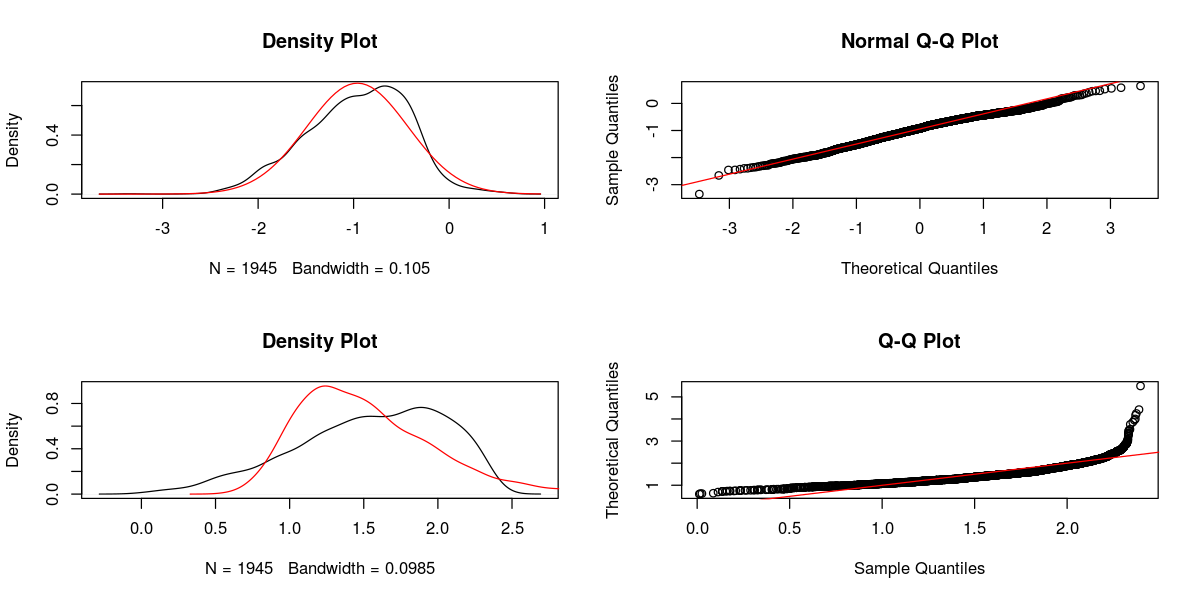

In [26]:
only_int_combat_data_df <- ComBat(dat=data_df, batch=design_df$batch, mod=modcombat, par.prior=TRUE, prior.plots=TRUE)

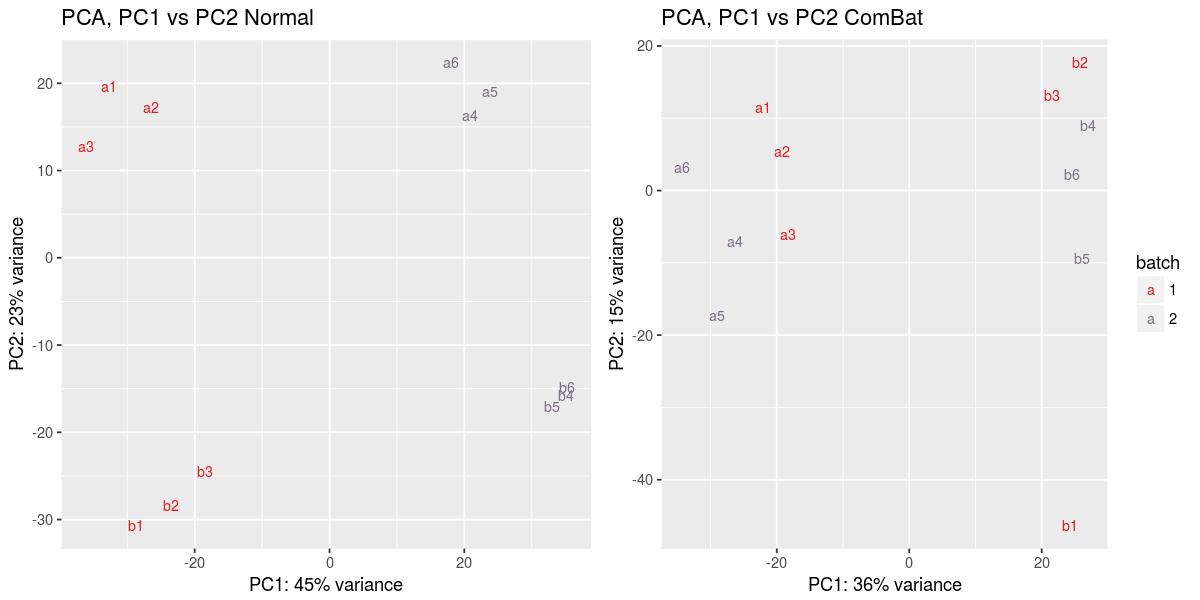

In [27]:
p1_1 <- plot_pca(data_df, design_df, 1, 2, "batch", colors=4, custom_names=design_df$name, legend=F, title_app = "Normal")
p1_2 <- plot_pca(only_int_combat_data_df, design_df, 1, 2, "batch", colors=4, custom_names=design_df$name, legend=T, title_app="ComBat")
options(repr.plot.width=10, repr.plot.height=5)
multiplot(p1_1, p1_2, cols=2)


### Statistics

In [28]:
print("ComBat statistics (only intercept)")

p_vals <- unlist(apply(only_int_combat_data_df, 1, calculate_anova, cond=design_df$condition))
q_vals <- as.numeric(p.adjust(p_vals, method="BH"))
sig_indices <- which(q_vals < 0.1)

print(paste("P-vals below 0.1:", length(p_vals[which(p_vals < 0.1)])))
print(paste("Spike-in count:", length(spike_col[spike_col])))
print(paste("Passing FDR threshold:", length(q_vals[which(q_vals < 0.1)])))

truth_vector <- get_truth_vector(q_vals < 0.1, spike_col)
print_truth_summary(truth_vector)
sig_vectors[["combat_no_factor"]] <- truth_vector
q_vectors[["combat_no_factor"]] <- q_vals

[1] "ComBat statistics (only intercept)"
[1] "P-vals below 0.1: 969"
[1] "Spike-in count: 424"
[1] "Passing FDR threshold: 817"
truth_vector
  FN   FP   TN   TP 
  38  431 1090  386 
[1] "Precision: 0.472"
[1] "Specificity: 0.717"
[1] "Recall: 0.91"
[1] "F-score: 0.622"


# Estimate surrogate variation

In [29]:
mod <- model.matrix(~condition, data=design_df)
mod0 <- model.matrix(~1, data=design_df)
n.sv <- num.sv(data_df, mod, method="leek")
n.sv

[1] 3

In [30]:
data_m <- as.matrix(data_df)
typeof(as.matrix(data_df))

[1] "double"

In [31]:
svobj <- sva(data_m, mod, mod0, n.sv=n.sv)

Number of significant surrogate variables is:  3 
Iteration (out of 5 ):1  2  3  4  5  

In [32]:
str(svobj)

List of 4
 $ sv       : num [1:12, 1:3] 0.233 0.17 0.293 -0.28 -0.254 ...
 $ pprob.gam: num [1:1945] 0.998 0.69 0.986 0.975 0.48 ...
 $ pprob.b  : num [1:1945] 0.694 0.327 0.698 0.397 1 ...
 $ n.sv     : num 3


In [33]:
pValues <- f.pvalue(data_m, mod, mod0)
qValues <- p.adjust(pValues, method="BH")
print(paste("Total:", length(pValues)))
print(paste("Sig: ", length(qValues[which(qValues < 0.1)])))

[1] "Total: 1945"
[1] "Sig:  505"


In [34]:
modSv <- cbind(mod, svobj$sv)
mod0Sv <- cbind(mod0, svobj$sv)
pValuesSv <- f.pvalue(data_m, modSv, mod0Sv)
qValuesSv <- p.adjust(pValuesSv, method="BH")
print(paste("Sig:", length(qValuesSv[which(qValuesSv < 0.1)])))

[1] "Sig: 947"


In [35]:
truth_vector <- get_truth_vector(measured_pos_vect=qValuesSv < 0.1, actually_pos_vect=spike_col)
print_truth_summary(truth_vector)
sig_vectors[["sva"]] <- truth_vector
q_vectors[["sva"]] <- qValuesSv

truth_vector
 FN  FP  TN  TP 
 30 553 968 394 
[1] "Precision: 0.416"
[1] "Specificity: 0.636"
[1] "Recall: 0.929"
[1] "F-score: 0.575"


# Summarize significance

In [36]:
print(paste("True positives:", length(spike_col[spike_col])))

print("Sig counts:")
for (name in names(q_vectors)) {
    q_vector <- q_vectors[[name]]
    print(paste0(name, ": ", length(q_vector[which(q_vector < 0.1)])))
}

[1] "True positives: 424"
[1] "Sig counts:"
[1] "default: 505"
[1] "batch_corr: 754"
[1] "combat: 867"
[1] "combat_no_factor: 817"
[1] "sva: 947"


In [37]:
for (sig_v in names(sig_vectors)) {
    print(paste("===", sig_v, "==="))
    print_truth_summary(sig_vectors[[sig_v]])
}

[1] "=== default ==="
truth_vector
  FN   FP   TN   TP 
  76  157 1364  348 
[1] "Precision: 0.689"
[1] "Specificity: 0.897"
[1] "Recall: 0.821"
[1] "F-score: 0.749"
[1] "=== batch_corr ==="
truth_vector
  FN   FP   TN   TP 
  45  375 1146  379 
[1] "Precision: 0.503"
[1] "Specificity: 0.753"
[1] "Recall: 0.894"
[1] "F-score: 0.643"
[1] "=== combat ==="
truth_vector
  FN   FP   TN   TP 
  39  482 1039  385 
[1] "Precision: 0.444"
[1] "Specificity: 0.683"
[1] "Recall: 0.908"
[1] "F-score: 0.596"
[1] "=== combat_no_factor ==="
truth_vector
  FN   FP   TN   TP 
  38  431 1090  386 
[1] "Precision: 0.472"
[1] "Specificity: 0.717"
[1] "Recall: 0.91"
[1] "F-score: 0.622"
[1] "=== sva ==="
truth_vector
 FN  FP  TN  TP 
 30 553 968 394 
[1] "Precision: 0.416"
[1] "Specificity: 0.636"
[1] "Recall: 0.929"
[1] "F-score: 0.575"
